In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# File paths


def extract_group_expr(sample):
    parts = sample.split('_')
    if len(parts) >= 3:
        return f"{parts[1]}_{parts[2]}"
    return "Unknown"

def extract_group_oxid(sample):
    parts = sample.split('_')
    if len(parts) >= 5:
        return f"{parts[2]}_{parts[3]}"
    return "Unknown"

def load_data(EXPR_PATH, OXID_PATH):
    print("Loading expression data...")
    expr_df = pd.read_csv(EXPR_PATH)
    
    print("Loading oxidation data...")
    oxid_df = pd.read_csv(OXID_PATH)
    
    expr_df['Group'] = expr_df['Sample'].apply(extract_group_expr)
    oxid_df['Group'] = oxid_df['sample'].apply(extract_group_oxid)
    
    print("Expression data shape:", expr_df.shape)
    print("Oxidation data shape:", oxid_df.shape)
    
    return expr_df, oxid_df

def merge_data_for_correlation(expr_df, oxid_df):
    # Simple gene column detection - just look for 'gene' or 'Gene'
    if 'gene' in expr_df.columns:
        gene_col_expr = 'gene'
    elif 'Gene' in expr_df.columns:
        gene_col_expr = 'Gene'
    else:
        gene_col_expr = expr_df.columns[0]  # fallback to first column
    
    if 'gene' in oxid_df.columns:
        gene_col_oxid = 'gene'
    elif 'Gene' in oxid_df.columns:
        gene_col_oxid = 'Gene'
    else:
        gene_col_oxid = oxid_df.columns[0]  # fallback to first column
    
    print(f"Using gene column '{gene_col_expr}' from expression data")
    print(f"Using gene column '{gene_col_oxid}' from oxidation data")
    
    # Prepare data for merging
    expr_for_merge = expr_df[[gene_col_expr, 'Sample', 'Group', 'Expression_level']].copy()
    expr_for_merge.rename(columns={gene_col_expr: 'Gene'}, inplace=True)
    
    oxid_for_merge = oxid_df[[gene_col_oxid, 'sample', 'Group', 'median_normalized_damage']].copy()
    oxid_for_merge.rename(columns={gene_col_oxid: 'Gene', 'sample': 'Sample'}, inplace=True)
    
    # Merge datasets
    merged_df = pd.merge(expr_for_merge, oxid_for_merge, on=['Gene', 'Group'], 
                        suffixes=('_expr', '_oxid'), how='inner')
    
    print(f"Merged data shape: {merged_df.shape}")
    print("Groups found:", merged_df['Group'].unique())
    
    return merged_df

def analyze_zero_inflation_detailed(merged_df):
    """
    Detailed analysis of zero inflation patterns
    """
    print("\n" + "="*80)
    print("DETAILED ZERO INFLATION ANALYSIS")
    print("="*80)
    
    analysis_results = {}
    
    for group in merged_df['Group'].unique():
        group_data = merged_df[merged_df['Group'] == group]
        
        # Basic zero inflation stats
        total_points = len(group_data)
        zero_points = len(group_data[group_data['Expression_level'] == 0])
        zero_percentage = (zero_points / total_points) * 100
        
        # Expression distribution analysis
        expr_vals = group_data['Expression_level']
        non_zero_expr = expr_vals[expr_vals > 0]
        
        print(f"\nGroup: {group}")
        print(f"Total data points: {total_points:,}")
        print(f"Zero expression points: {zero_points:,}")
        print(f"Zero inflation: {zero_percentage:.1f}%")
        print(f"Non-zero expression range: {non_zero_expr.min():.2f} - {non_zero_expr.max():.2f}")
        print(f"Non-zero mean: {non_zero_expr.mean():.2f}")
        print(f"Non-zero median: {non_zero_expr.median():.2f}")
        
        # Oxidation damage distribution
        oxid_vals = group_data['median_normalized_damage']
        print(f"Oxidation range: {oxid_vals.min():.4f} - {oxid_vals.max():.4f}")
        print(f"Oxidation mean: {oxid_vals.mean():.4f}")
        
        # Store for later analysis
        analysis_results[group] = {
            'total_points': total_points,
            'zero_points': zero_points,
            'zero_percentage': zero_percentage,
            'non_zero_expr': non_zero_expr,
            'oxid_vals': oxid_vals,
            'group_data': group_data
        }
    
    return analysis_results

def robust_correlation_analysis(analysis_results, sample_size=1000000000):
    """
    Perform robust correlation analysis using multiple approaches
    """
    print("\n" + "="*80)
    print("ROBUST CORRELATION ANALYSIS")
    print("="*80)
    
    correlation_results = {}
    
    for group, data_info in analysis_results.items():
        print(f"\nAnalyzing group: {group}")
        
        group_data = data_info['group_data']
        
        # Sample data if too large
        if len(group_data) > sample_size:
            print(f"Sampling {sample_size:,} points from {len(group_data):,} total")
            group_data_sample = group_data.sample(n=sample_size, random_state=42)
        else:
            group_data_sample = group_data.copy()
        
        expr_vals = group_data_sample['Expression_level'].values
        oxid_vals = group_data_sample['median_normalized_damage'].values
        
        results = {}
        
        # 1. Spearman correlation (most robust for zero-inflated data)
        try:
            spearman_coef, spearman_p = spearmanr(expr_vals, oxid_vals)
            results['spearman'] = {
                'coefficient': spearman_coef,
                'pvalue': spearman_p,
                'interpretation': 'Rank-based correlation (robust to zeros and outliers)'
            }
            print(f"Spearman correlation: ρ = {spearman_coef:.4f}, p = {spearman_p:.2e}")
        except Exception as e:
            print(f"Spearman correlation failed: {e}")
        
        # 2. Pearson correlation on all data
        try:
            pearson_coef, pearson_p = pearsonr(expr_vals, oxid_vals)
            results['pearson_all'] = {
                'coefficient': pearson_coef,
                'pvalue': pearson_p,
                'interpretation': 'Linear correlation (including zeros)'
            }
            print(f"Pearson correlation (all data): r = {pearson_coef:.4f}, p = {pearson_p:.2e}")
        except Exception as e:
            print(f"Pearson correlation failed: {e}")
        
        # 3. Pearson correlation on non-zero data only
        try:
            non_zero_mask = expr_vals > 0
            if np.sum(non_zero_mask) > 10:  # Need at least 10 non-zero points
                expr_nonzero = expr_vals[non_zero_mask]
                oxid_nonzero = oxid_vals[non_zero_mask]
                
                pearson_nz_coef, pearson_nz_p = pearsonr(expr_nonzero, oxid_nonzero)
                results['pearson_nonzero'] = {
                    'coefficient': pearson_nz_coef,
                    'pvalue': pearson_nz_p,
                    'n_points': len(expr_nonzero),
                    'interpretation': 'Linear correlation (non-zero expression only)'
                }
                print(f"Pearson correlation (non-zero only, n={len(expr_nonzero):,}): r = {pearson_nz_coef:.4f}, p = {pearson_nz_p:.2e}")
        except Exception as e:
            print(f"Pearson correlation (non-zero) failed: {e}")
        
        # 4. Linear regression on log-transformed data
        try:
            expr_log1p = np.log1p(expr_vals)  # log(1 + x) handles zeros
            
            # Remove infinite values
            finite_mask = np.isfinite(expr_log1p) & np.isfinite(oxid_vals)
            if np.sum(finite_mask) > 10:
                X = oxid_vals[finite_mask].reshape(-1, 1)
                y = expr_log1p[finite_mask]
                
                reg = LinearRegression()
                reg.fit(X, y)
                
                y_pred = reg.predict(X)
                r2 = r2_score(y, y_pred)
                
                results['linear_log'] = {
                    'coefficient': reg.coef_[0],
                    'intercept': reg.intercept_,
                    'r2': r2,
                    'n_points': len(y),
                    'interpretation': 'Effect of oxidation on log(1+expression)'
                }
                print(f"Linear regression (log1p transform): coef = {reg.coef_[0]:.4f}, R² = {r2:.4f}")
        except Exception as e:
            print(f"Linear regression (log transform) failed: {e}")
        
        # 5. Binned analysis - divide expression into bins
        try:
            # Create expression bins
            expr_bins = ['Zero', '(>0-1)', '(1-10)', '(10-100)', '(100-1000)', '(1000-10000)','(10000-100000)', '(>100000)']
            bin_conditions = [
                expr_vals == 0,
                (expr_vals > 0) & (expr_vals <= 1),
                (expr_vals > 1) & (expr_vals <= 10),
                (expr_vals > 10) & (expr_vals <= 100),
                (expr_vals > 100) & (expr_vals <= 1000),
                (expr_vals > 1000) & (expr_vals <= 10000),
                (expr_vals > 10000) & (expr_vals <= 100000),
                expr_vals > 100000
            ]
            
            bin_analysis = {}
            for i, (bin_name, condition) in enumerate(zip(expr_bins, bin_conditions)):
                if np.sum(condition) > 0:
                    bin_oxid = oxid_vals[condition]
                    bin_analysis[bin_name] = {
                        'count': np.sum(condition),
                        'oxid_mean': np.mean(bin_oxid),
                        'oxid_std': np.std(bin_oxid),
                        'oxid_median': np.median(bin_oxid)
                    }
            
            results['binned_analysis'] = bin_analysis
            
            print("Oxidation damage by expression bins:")
            for bin_name, bin_stats in bin_analysis.items():
                print(f"  {bin_name}: n={bin_stats['count']:,}, "
                      f"oxid_mean={bin_stats['oxid_mean']:.4f}±{bin_stats['oxid_std']:.4f}")
                      
        except Exception as e:
            print(f"Binned analysis failed: {e}")
        
        correlation_results[group] = results
    
    return correlation_results

def create_robust_visualizations(analysis_results, correlation_results):
    """
    Create visualizations focused on robust methods
    """
    groups = list(correlation_results.keys())
    n_groups = min(len(groups), 4)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 16))
    
    for i, group in enumerate(groups[:n_groups]):
        group_info = analysis_results[group]
        group_corr = correlation_results[group]
        group_data = group_info['group_data']
        
        # Sample for visualization if too large
        if len(group_data) > 50000:
            viz_data = group_data.sample(n=50000, random_state=42)
        else:
            viz_data = group_data
        
        # 1. Raw data scatter (log scale)
        ax1 = plt.subplot(4, n_groups, i + 1)
        
        # Separate zeros and non-zeros for better visualization
        zero_mask = viz_data['Expression_level'] == 0
        nonzero_mask = viz_data['Expression_level'] > 0
        
        if np.sum(zero_mask) > 0:
            ax1.scatter(viz_data.loc[zero_mask, 'median_normalized_damage'], 
                       np.full(np.sum(zero_mask), 0.1),  # Slightly above 0 for visibility
                       alpha=0.3, s=10, color='red', label=f'Zeros (n={np.sum(zero_mask):,})')
        
        if np.sum(nonzero_mask) > 0:
            ax1.scatter(viz_data.loc[nonzero_mask, 'median_normalized_damage'],
                       viz_data.loc[nonzero_mask, 'Expression_level'],
                       alpha=0.3, s=10, color='blue', label=f'Non-zeros')
        
        ax1.set_xlabel('Oxidation Damage')
        ax1.set_ylabel('Expression Level')
        ax1.set_yscale('log')
        ax1.set_title(f'{group}\nRaw Data (Log Scale)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Add Spearman correlation info
        if 'spearman' in group_corr:
            spearman_info = group_corr['spearman']
            ax1.text(0.02, 0.98, 
                    f"Spearman ρ: {spearman_info['coefficient']:.3f}\np: {spearman_info['pvalue']:.2e}",
                    transform=ax1.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # 2. Non-zero data only
        ax2 = plt.subplot(4, n_groups, n_groups + i + 1)
        
        nonzero_data = viz_data[viz_data['Expression_level'] > 0]
        if len(nonzero_data) > 0:
            ax2.scatter(nonzero_data['median_normalized_damage'],
                       nonzero_data['Expression_level'],
                       alpha=0.4, s=15, color='green')
            
            # Add trend line if correlation exists
            if 'pearson_nonzero' in group_corr:
                z = np.polyfit(nonzero_data['median_normalized_damage'], 
                              nonzero_data['Expression_level'], 1)
                p = np.poly1d(z)
                x_trend = np.linspace(nonzero_data['median_normalized_damage'].min(),
                                    nonzero_data['median_normalized_damage'].max(), 100)
                ax2.plot(x_trend, p(x_trend), 'r--', linewidth=2)
                
                pearson_nz = group_corr['pearson_nonzero']
                ax2.text(0.02, 0.98, 
                        f"Pearson r: {pearson_nz['coefficient']:.3f}\np: {pearson_nz['pvalue']:.2e}\nn: {pearson_nz['n_points']:,}",
                        transform=ax2.transAxes, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax2.set_xlabel('Oxidation Damage')
        ax2.set_ylabel('Expression Level')
        ax2.set_title(f'{group}\nNon-Zero Expression Only')
        ax2.grid(True, alpha=0.3)
        
        # 3. Log-transformed data
        ax3 = plt.subplot(4, n_groups, 2*n_groups + i + 1)
        
        expr_log1p = np.log1p(viz_data['Expression_level'])
        ax3.scatter(viz_data['median_normalized_damage'], expr_log1p,
                   alpha=0.4, s=15, color='purple')
        
        if 'linear_log' in group_corr:
            linear_log = group_corr['linear_log']
            z = np.polyfit(viz_data['median_normalized_damage'], expr_log1p, 1)
            p = np.poly1d(z)
            x_trend = np.linspace(viz_data['median_normalized_damage'].min(),
                                viz_data['median_normalized_damage'].max(), 100)
            ax3.plot(x_trend, p(x_trend), 'r--', linewidth=2)
            
            ax3.text(0.02, 0.98, 
                    f"Coef: {linear_log['coefficient']:.3f}\nR²: {linear_log['r2']:.3f}",
                    transform=ax3.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax3.set_xlabel('Oxidation Damage')
        ax3.set_ylabel('log(1 + Expression)')
        ax3.set_title(f'{group}\nLog-Transformed Expression')
        ax3.grid(True, alpha=0.3)
        
        # 4. Binned analysis
        ax4 = plt.subplot(4, n_groups, 3*n_groups + i + 1)
        
        if 'binned_analysis' in group_corr:
            bins_data = group_corr['binned_analysis']
            bin_names = list(bins_data.keys())
            bin_means = [bins_data[bn]['oxid_mean'] for bn in bin_names]
            bin_stds = [bins_data[bn]['oxid_std'] for bn in bin_names]
            
            x_pos = np.arange(len(bin_names))
            ax4.bar(x_pos, bin_means, yerr=bin_stds, capsize=5, 
                   color='orange', alpha=0.7)
            ax4.set_xlabel('Expression Bins')
            ax4.set_ylabel('Mean Oxidation Damage')
            ax4.set_title(f'{group}\nOxidation by Expression Bins')
            ax4.set_xticks(x_pos)
            ax4.set_xticklabels(bin_names, rotation=45, ha='right')
            ax4.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.suptitle('Robust Analysis of Zero-Inflated Expression Data', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.show()

def print_final_summary(correlation_results):
    """
    Print a comprehensive summary of findings
    """
    print("\n" + "="*100)
    print("FINAL SUMMARY: CORRELATION BETWEEN OXIDATION DAMAGE AND GENE EXPRESSION")
    print("="*100)
    
    for group, results in correlation_results.items():
        print(f"\n{group.upper()}:")
        print("-" * 50)
        
        # Spearman (most reliable for this data)
        if 'spearman' in results:
            spearman = results['spearman']
            strength = "weak" if abs(spearman['coefficient']) < 0.1 else "moderate" if abs(spearman['coefficient']) < 0.3 else "strong"
            direction = "positive" if spearman['coefficient'] > 0 else "negative"
            significance = "significant" if spearman['pvalue'] < 0.05 else "not significant"
            
            print(f"Spearman Rank Correlation: ρ = {spearman['coefficient']:.4f} (p = {spearman['pvalue']:.2e})")
            print(f"→ {strength.title()} {direction} correlation, {significance}")
        
        # Non-zero analysis
        if 'pearson_nonzero' in results:
            pearson_nz = results['pearson_nonzero']
            print(f"Non-zero expression only: r = {pearson_nz['coefficient']:.4f} (p = {pearson_nz['pvalue']:.2e}, n = {pearson_nz['n_points']:,})")
        
        # Log-transformed analysis
        if 'linear_log' in results:
            linear_log = results['linear_log']
            print(f"Log-transformed model: coef = {linear_log['coefficient']:.4f} (R² = {linear_log['r2']:.4f})")
            
            if linear_log['coefficient'] > 0:
                print("→ Higher oxidation damage associated with higher expression")
            else:
                print("→ Higher oxidation damage associated with lower expression")
    
    print(f"\n{'='*100}")
    print("INTERPRETATION GUIDE:")
    print("• Spearman correlation is most reliable for zero-inflated data (58%+ zeros)")
    print("• Non-zero analysis shows relationship among expressed genes only")
    print("• Log-transformed analysis handles zeros while preserving all data")
    print("• Small correlation coefficients can still be biologically meaningful with large sample sizes")

def create_robust_visualizations_separate_rows(analysis_results, correlation_results, save_path="./plots/"):
    """
    Create visualizations with each row saved as a separate 2x2 figure
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    groups = list(correlation_results.keys())
    n_groups = min(len(groups), 4)
    
    # Define the 4 different plot types
    plot_types = [
        {
            'name': 'raw_data_log',
            'title': 'Raw Data (Log Scale)',
            'function': 'plot_raw_data_log'
        },
        {
            'name': 'nonzero_only',
            'title': 'Non-Zero Expression Only', 
            'function': 'plot_nonzero_only'
        },
        {
            'name': 'log_transformed',
            'title': 'Log-Transformed Expression',
            'function': 'plot_log_transformed'
        },
        {
            'name': 'binned_analysis',
            'title': 'Oxidation by Expression Bins',
            'function': 'plot_binned_analysis'
        }
    ]
    
    # Create each row as a separate 2x2 figure
    for plot_idx, plot_info in enumerate(plot_types):
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'{plot_info["title"]} - All Groups', fontsize=16, fontweight='bold')
        
        # Flatten axes for easier indexing
        axes_flat = axes.flatten()
        
        for i, group in enumerate(groups[:4]):  # Maximum 4 groups for 2x2
            if i >= 4:
                break
                
            ax = axes_flat[i]
            group_info = analysis_results[group]
            group_corr = correlation_results[group]
            group_data = group_info['group_data']
            
            # Sample for visualization if too large
            if len(group_data) > 50000:
                viz_data = group_data.sample(n=50000, random_state=42)
            else:
                viz_data = group_data
            
            # Call the appropriate plotting function
            if plot_idx == 0:  # Raw data log
                plot_raw_data_log(ax, viz_data, group_corr, group)
            elif plot_idx == 1:  # Non-zero only
                plot_nonzero_only(ax, viz_data, group_corr, group)
            elif plot_idx == 2:  # Log transformed
                plot_log_transformed(ax, viz_data, group_corr, group)
            elif plot_idx == 3:  # Binned analysis
                plot_binned_analysis(ax, viz_data, group_corr, group)
        
        # Hide unused subplots if we have fewer than 4 groups
        for i in range(len(groups), 4):
            axes_flat[i].set_visible(False)
        
        plt.tight_layout()
        
        # Save the figure
        filename = f"{plot_info['name']}.png"
        filepath = os.path.join(save_path, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"Saved: {filepath}")
        
        plt.show()

def plot_raw_data_log(ax, viz_data, group_corr, group):
    """Plot raw data with log scale"""
    # Separate zeros and non-zeros for better visualization
    zero_mask = viz_data['Expression_level'] == 0
    nonzero_mask = viz_data['Expression_level'] > 0
    
    if np.sum(zero_mask) > 0:
        ax.scatter(viz_data.loc[zero_mask, 'median_normalized_damage'], 
                   np.full(np.sum(zero_mask), 0.1),  # Slightly above 0 for visibility
                   alpha=0.3, s=10, color='red', label=f'Zeros (n={np.sum(zero_mask):,})')
    
    if np.sum(nonzero_mask) > 0:
        ax.scatter(viz_data.loc[nonzero_mask, 'median_normalized_damage'],
                   viz_data.loc[nonzero_mask, 'Expression_level'],
                   alpha=0.3, s=10, color='blue', label=f'Non-zeros')
    
    ax.set_xlabel('Oxidation Damage')
    ax.set_ylabel('Expression Level')
    ax.set_yscale('log')
    ax.set_title(f'{group}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add Spearman correlation info
    if 'spearman' in group_corr:
        spearman_info = group_corr['spearman']
        ax.text(0.02, 0.98, 
                f"Spearman ρ: {spearman_info['coefficient']:.3f}\np: {spearman_info['pvalue']:.2e}",
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

def plot_nonzero_only(ax, viz_data, group_corr, group):
    """Plot non-zero data only"""
    nonzero_data = viz_data[viz_data['Expression_level'] > 0]
    if len(nonzero_data) > 0:
        ax.scatter(nonzero_data['median_normalized_damage'],
                   nonzero_data['Expression_level'],
                   alpha=0.4, s=15, color='green')
        
        # Add trend line if correlation exists
        if 'pearson_nonzero' in group_corr:
            z = np.polyfit(nonzero_data['median_normalized_damage'], 
                          nonzero_data['Expression_level'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(nonzero_data['median_normalized_damage'].min(),
                                nonzero_data['median_normalized_damage'].max(), 100)
            ax.plot(x_trend, p(x_trend), 'r--', linewidth=2)
            
            pearson_nz = group_corr['pearson_nonzero']
            ax.text(0.02, 0.98, 
                    f"Pearson r: {pearson_nz['coefficient']:.3f}\np: {pearson_nz['pvalue']:.2e}\nn: {pearson_nz['n_points']:,}",
                    transform=ax.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Oxidation Damage')
    ax.set_ylabel('Expression Level')
    ax.set_title(f'{group}')
    ax.grid(True, alpha=0.3)

def plot_log_transformed(ax, viz_data, group_corr, group):
    """Plot log-transformed data"""
    expr_log1p = np.log1p(viz_data['Expression_level'])
    ax.scatter(viz_data['median_normalized_damage'], expr_log1p,
               alpha=0.4, s=15, color='purple')
    
    if 'linear_log' in group_corr:
        linear_log = group_corr['linear_log']
        z = np.polyfit(viz_data['median_normalized_damage'], expr_log1p, 1)
        p = np.poly1d(z)
        x_trend = np.linspace(viz_data['median_normalized_damage'].min(),
                            viz_data['median_normalized_damage'].max(), 100)
        ax.plot(x_trend, p(x_trend), 'r--', linewidth=2)
        
        ax.text(0.02, 0.98, 
                f"Coef: {linear_log['coefficient']:.3f}\nR²: {linear_log['r2']:.3f}",
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Oxidation Damage')
    ax.set_ylabel('log(1 + Expression)')
    ax.set_title(f'{group}')
    ax.grid(True, alpha=0.3)

def plot_binned_analysis(ax, viz_data, group_corr, group):
    """Plot binned analysis"""
    if 'binned_analysis' in group_corr:
        bins_data = group_corr['binned_analysis']
        bin_names = list(bins_data.keys())
        bin_means = [bins_data[bn]['oxid_mean'] for bn in bin_names]
        bin_stds = [bins_data[bn]['oxid_std'] for bn in bin_names]
        
        x_pos = np.arange(len(bin_names))
        ax.bar(x_pos, bin_means, yerr=bin_stds, capsize=5, 
               color='orange', alpha=0.7)
        ax.set_xlabel('Expression Bins')
        ax.set_ylabel('Mean Oxidation Damage')
        ax.set_title(f'{group}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(bin_names, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)

# Example usage:
# Replace the original create_robust_visualizations call with:
# create_robust_visualizations_separate_rows(analysis_results, correlation_results, save_path="./plots/")


Loading expression data...
Loading oxidation data...
Expression data shape: (1052980, 5)
Oxidation data shape: (3102760, 11)
Using gene column 'Gene' from expression data
Using gene column 'gene' from oxidation data
Merged data shape: (10289000, 6)
Groups found: ['Ctrl_morning' 'CRS_morning' 'Ctrl_evening' 'CRS_evening']

DETAILED ZERO INFLATION ANALYSIS

Group: Ctrl_morning
Total data points: 2,572,250
Zero expression points: 1,500,670
Zero inflation: 58.3%
Non-zero expression range: 0.00 - 347592.22
Non-zero mean: 43.88
Non-zero median: 4.55
Oxidation range: 0.0000 - 2451.9427
Oxidation mean: 1.0148

Group: CRS_morning
Total data points: 2,572,250
Zero expression points: 1,509,960
Zero inflation: 58.7%
Non-zero expression range: 0.00 - 332779.55
Non-zero mean: 44.21
Non-zero median: 4.57
Oxidation range: 0.0000 - 1687.2392
Oxidation mean: 1.0413

Group: Ctrl_evening
Total data points: 2,572,250
Zero expression points: 1,494,320
Zero inflation: 58.1%
Non-zero expression range: 0.00 - 

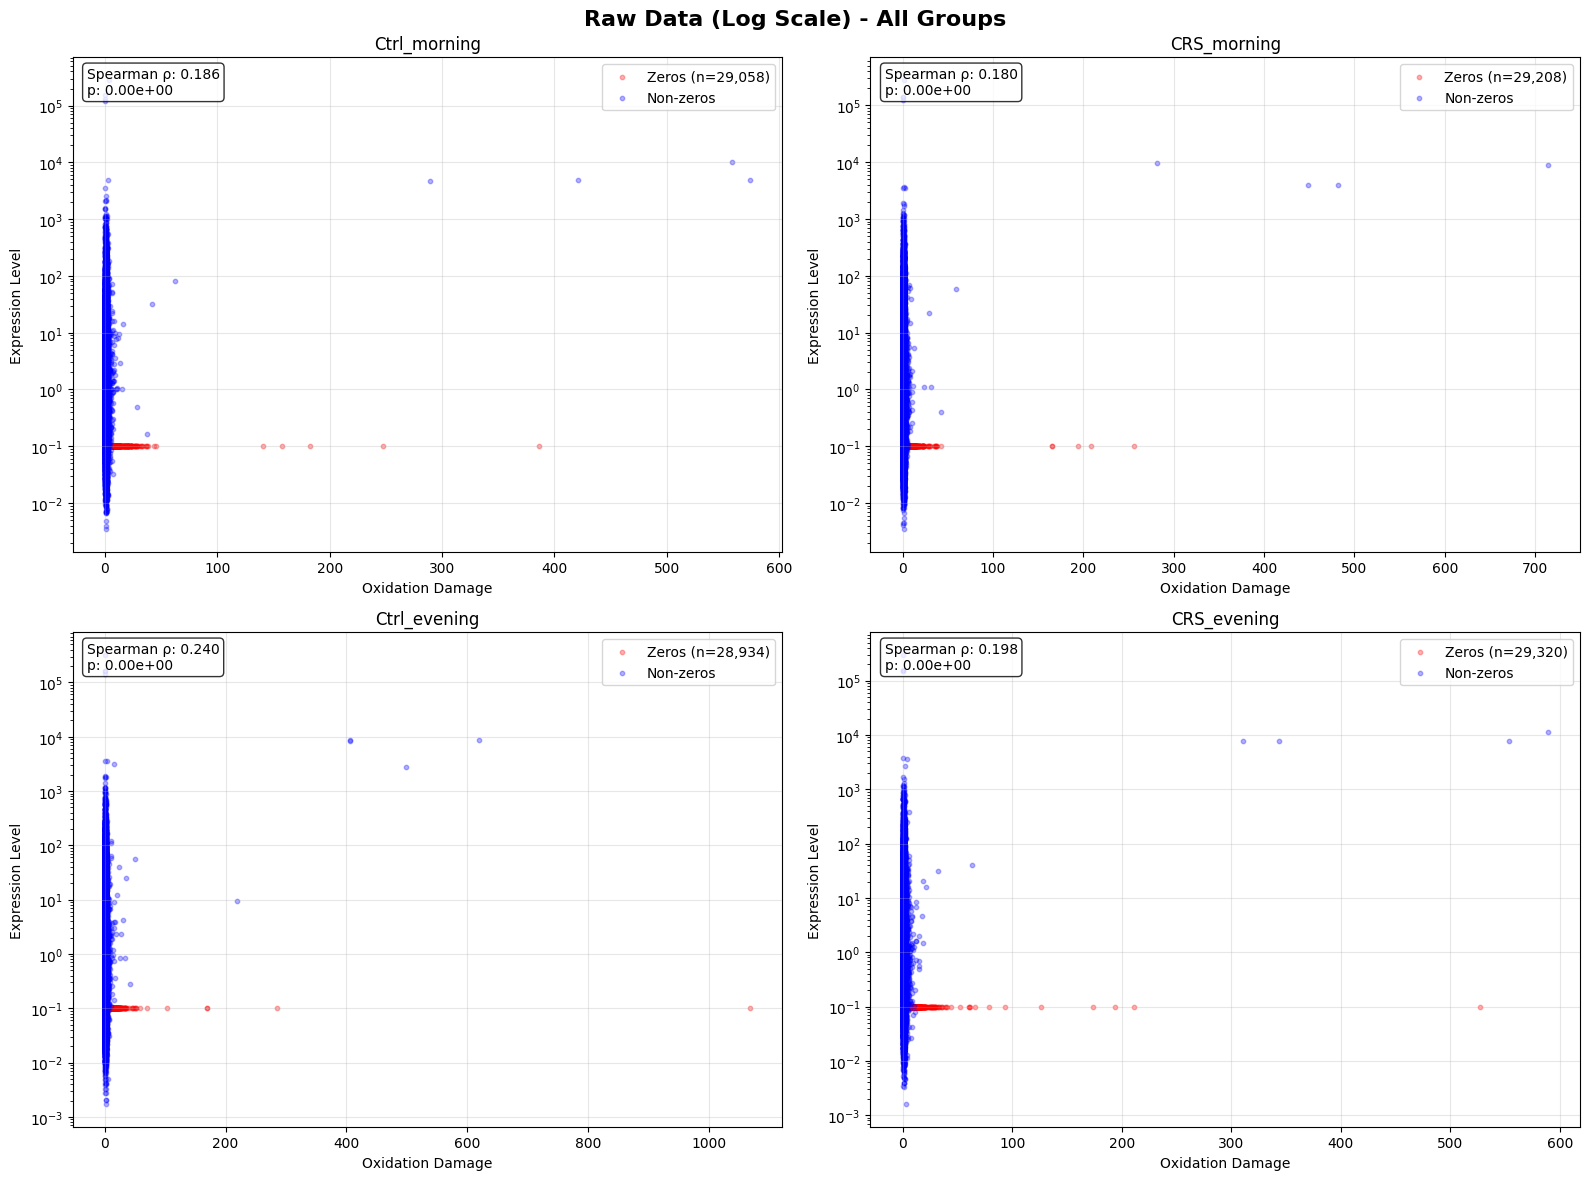

Saved: ./plots/nonzero_only.png


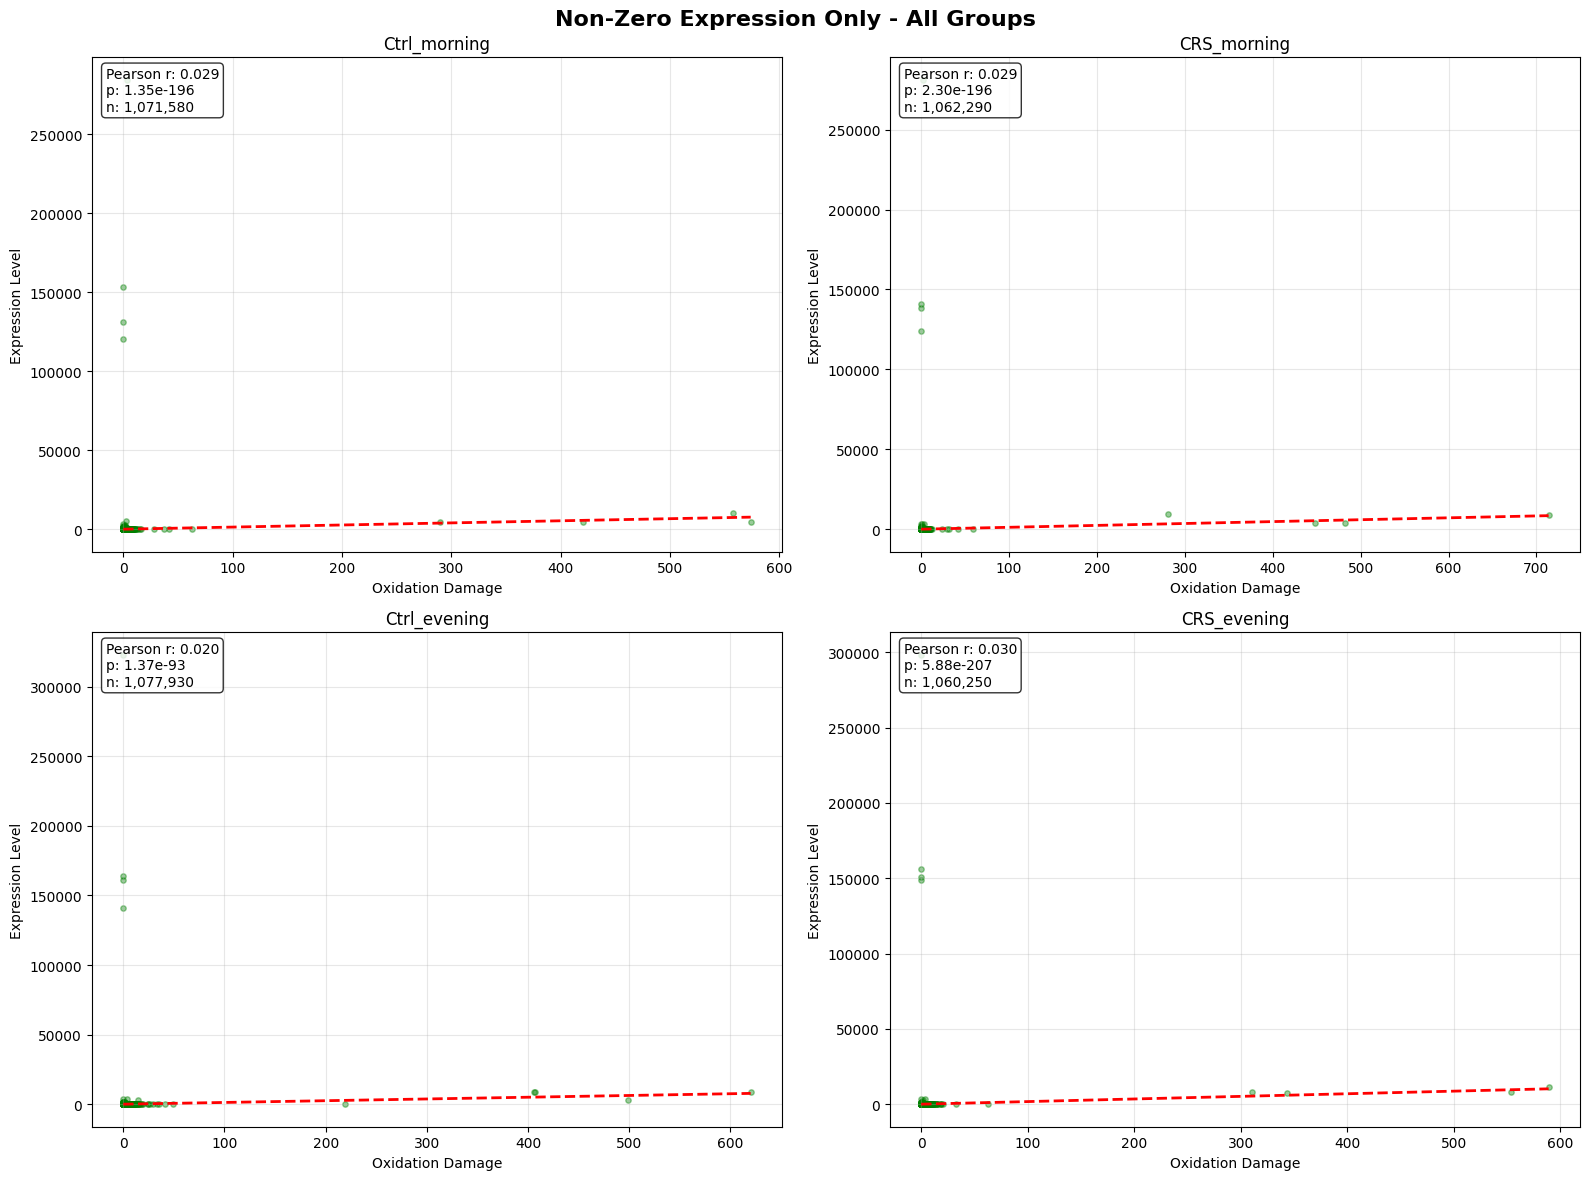

Saved: ./plots/log_transformed.png


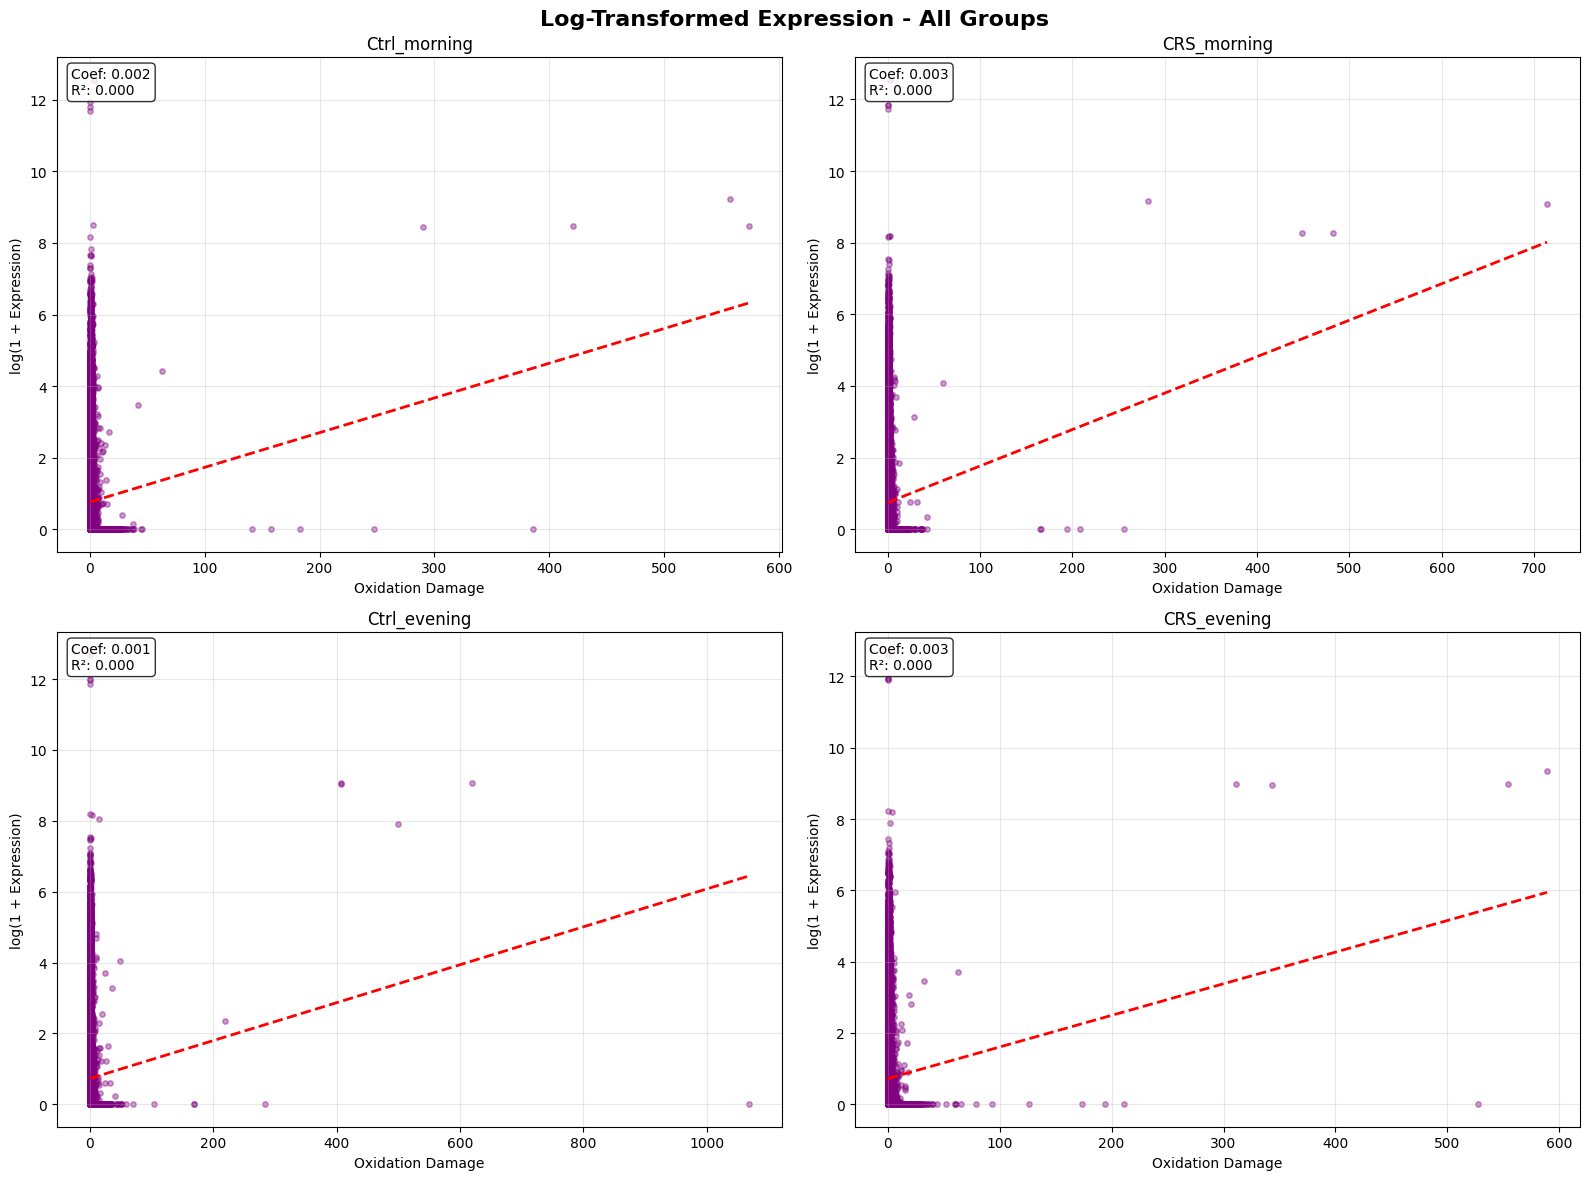

Saved: ./plots/binned_analysis.png


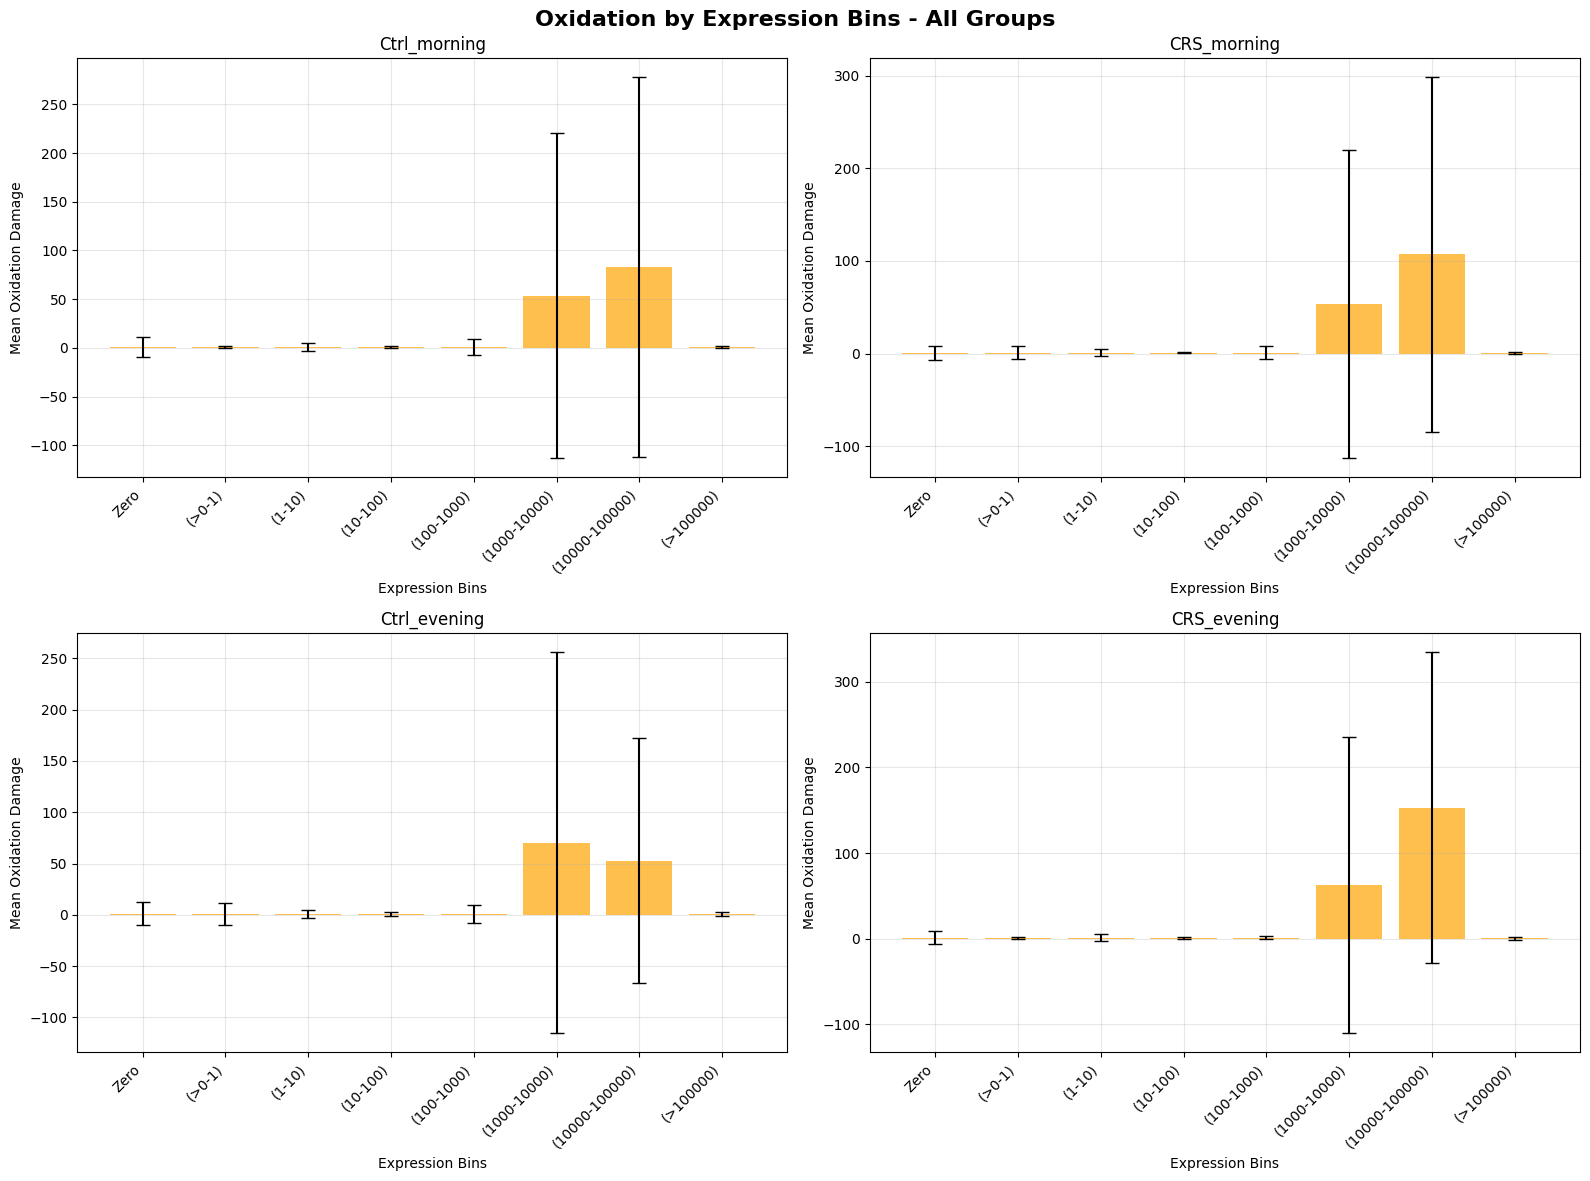


FINAL SUMMARY: CORRELATION BETWEEN OXIDATION DAMAGE AND GENE EXPRESSION

CTRL_MORNING:
--------------------------------------------------
Spearman Rank Correlation: ρ = 0.1859 (p = 0.00e+00)
→ Moderate positive correlation, significant
Non-zero expression only: r = 0.0289 (p = 1.35e-196, n = 1,071,580)
Log-transformed model: coef = 0.0022 (R² = 0.0002)
→ Higher oxidation damage associated with higher expression

CRS_MORNING:
--------------------------------------------------
Spearman Rank Correlation: ρ = 0.1797 (p = 0.00e+00)
→ Moderate positive correlation, significant
Non-zero expression only: r = 0.0290 (p = 2.30e-196, n = 1,062,290)
Log-transformed model: coef = 0.0031 (R² = 0.0003)
→ Higher oxidation damage associated with higher expression

CTRL_EVENING:
--------------------------------------------------
Spearman Rank Correlation: ρ = 0.2395 (p = 0.00e+00)
→ Moderate positive correlation, significant
Non-zero expression only: r = 0.0198 (p = 1.37e-93, n = 1,077,930)
Log-transfo

In [29]:
EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
OXID_PATH = "../data_normalized/gene_bodies_Normalized.csv"

expr_df, oxid_df = load_data(EXPR_PATH, OXID_PATH)
        
# Merge data
merged_df = merge_data_for_correlation(expr_df, oxid_df)
        
# Detailed zero inflation analysis
analysis_results = analyze_zero_inflation_detailed(merged_df)
        
# Robust correlation analysis (avoiding problematic Poisson regression)
correlation_results = robust_correlation_analysis(analysis_results)
        
# Create robust visualizations
create_robust_visualizations_separate_rows(analysis_results, correlation_results)
        
# Print final summary
print_final_summary(correlation_results)
        
print(f"\nAnalysis complete! Used robust methods appropriate for zero-inflated expression data.")


Loading expression data...
Loading oxidation data...
Expression data shape: (1052980, 5)
Oxidation data shape: (3128080, 11)
Using gene column 'Gene' from expression data
Using gene column 'gene' from oxidation data
Merged data shape: (10408200, 6)
Groups found: ['Ctrl_morning' 'CRS_morning' 'Ctrl_evening' 'CRS_evening']

DETAILED ZERO INFLATION ANALYSIS

Group: Ctrl_morning
Total data points: 2,602,050
Zero expression points: 1,530,430
Zero inflation: 58.8%
Non-zero expression range: 0.00 - 347592.22
Non-zero mean: 43.88
Non-zero median: 4.55
Oxidation range: 0.0000 - 927.4174
Oxidation mean: 0.9877

Group: CRS_morning
Total data points: 2,602,050
Zero expression points: 1,539,700
Zero inflation: 59.2%
Non-zero expression range: 0.00 - 332779.55
Non-zero mean: 44.21
Non-zero median: 4.57
Oxidation range: 0.0000 - 839.3028
Oxidation mean: 0.9979

Group: Ctrl_evening
Total data points: 2,602,050
Zero expression points: 1,524,050
Zero inflation: 58.6%
Non-zero expression range: 0.00 - 36

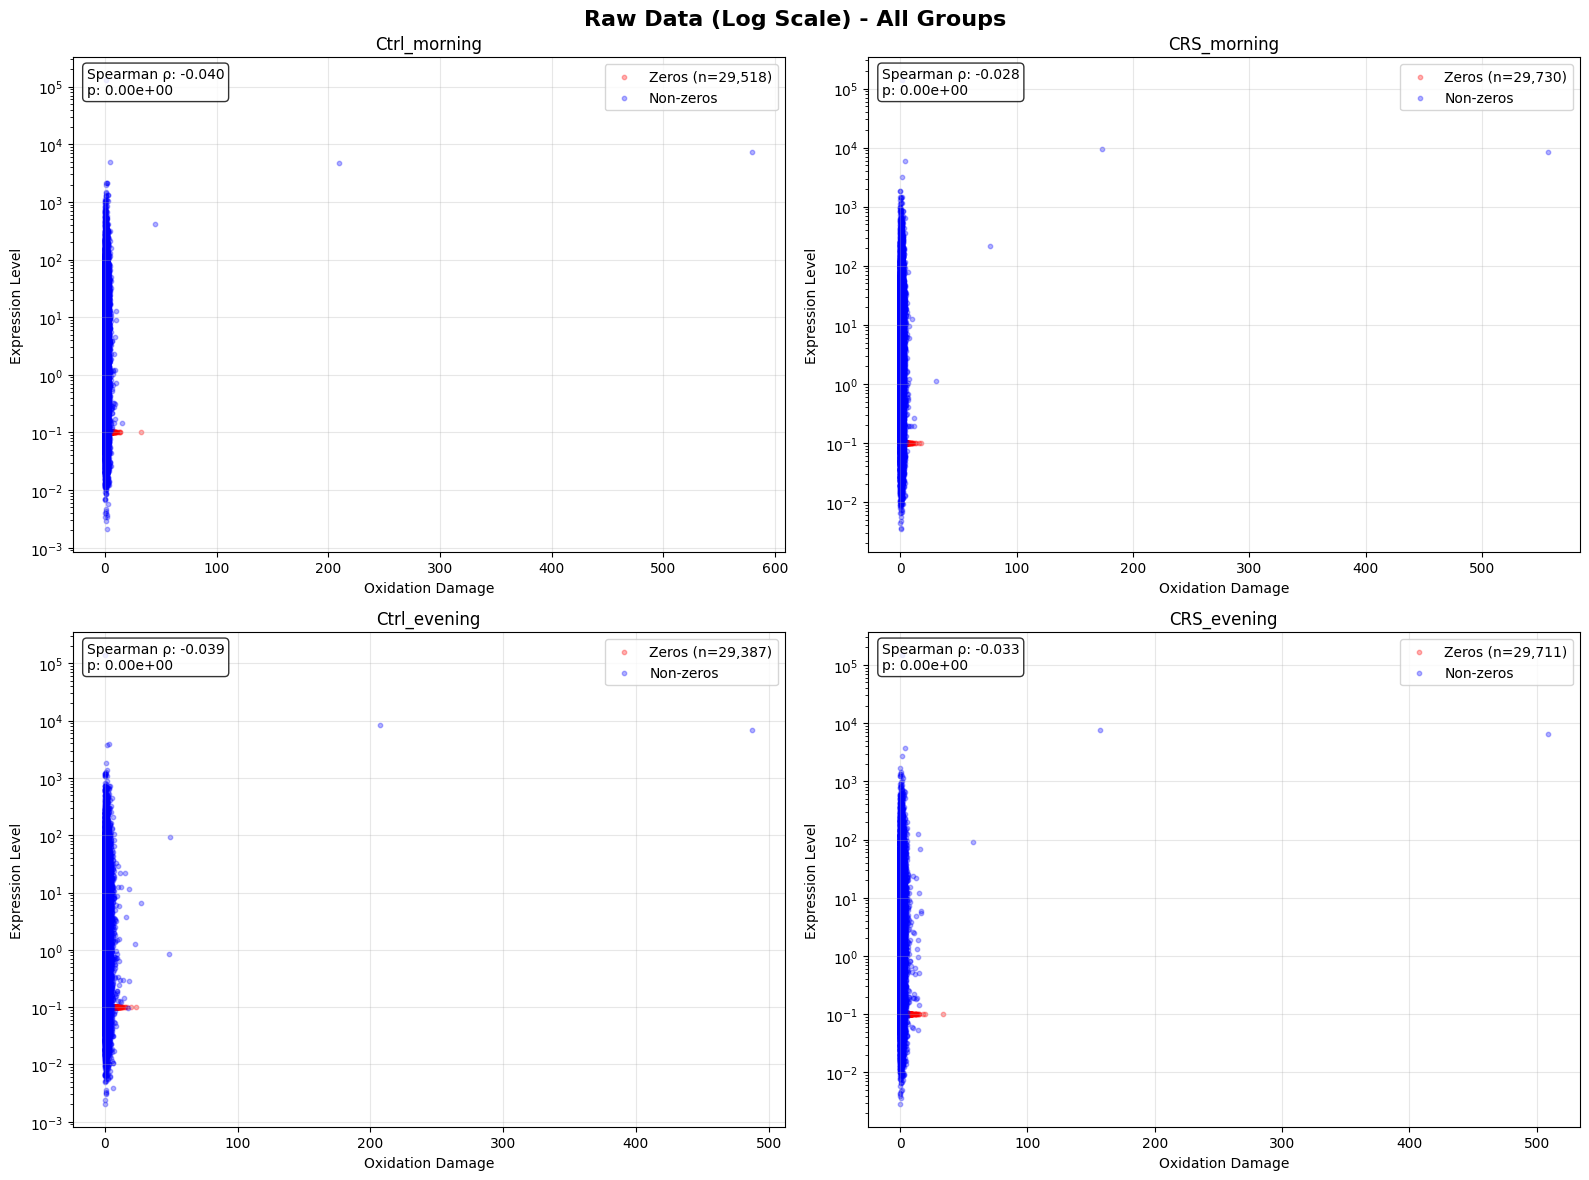

Saved: ./plots/nonzero_only.png


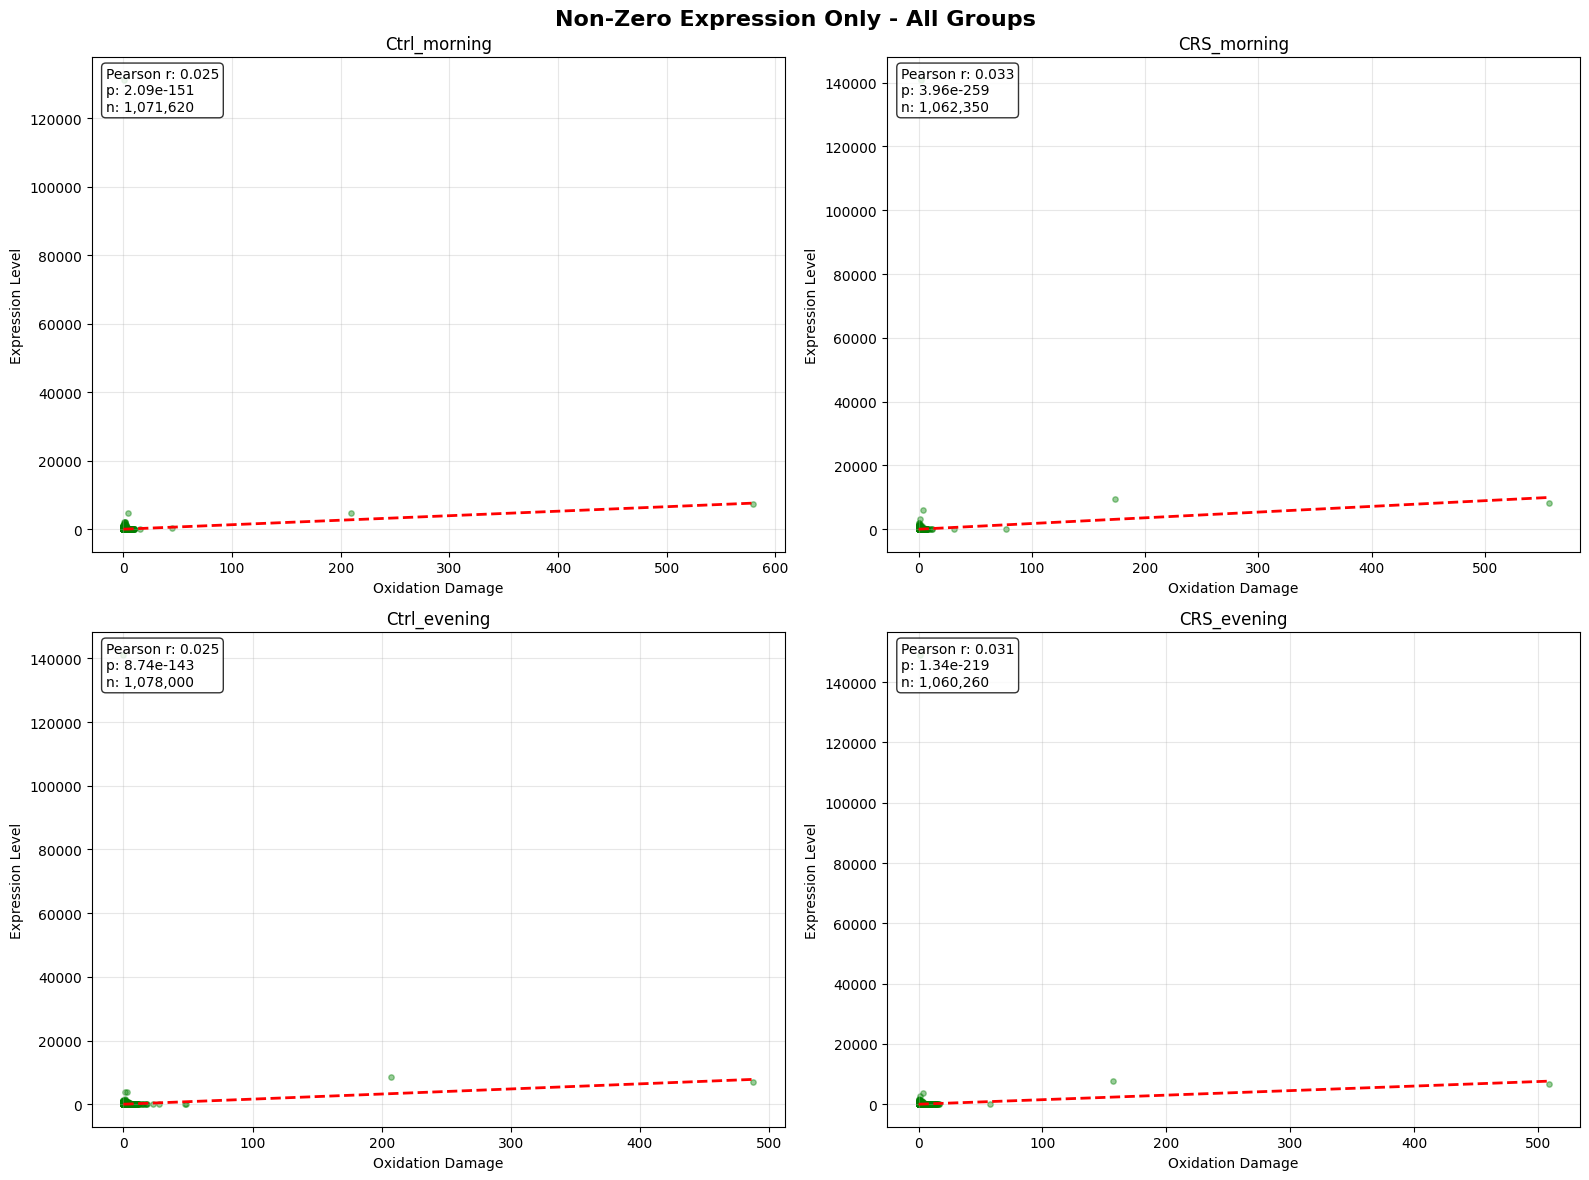

Saved: ./plots/log_transformed.png


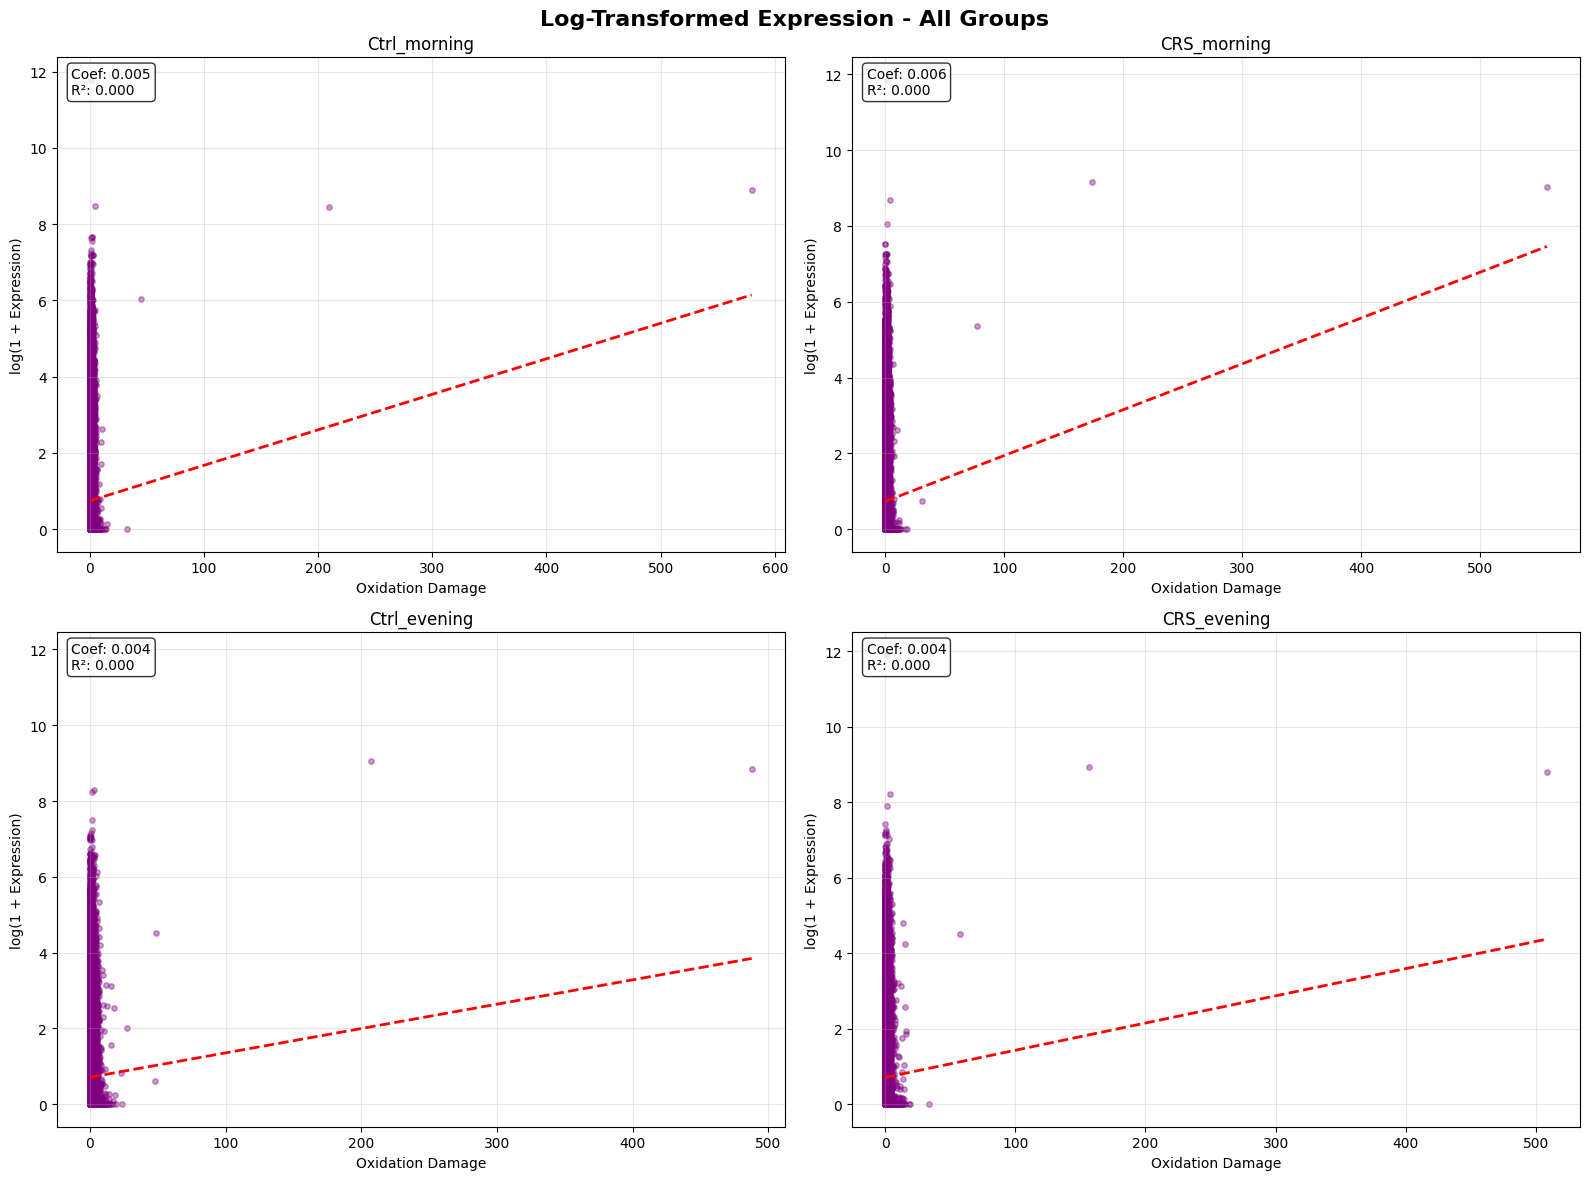

Saved: ./plots/binned_analysis.png


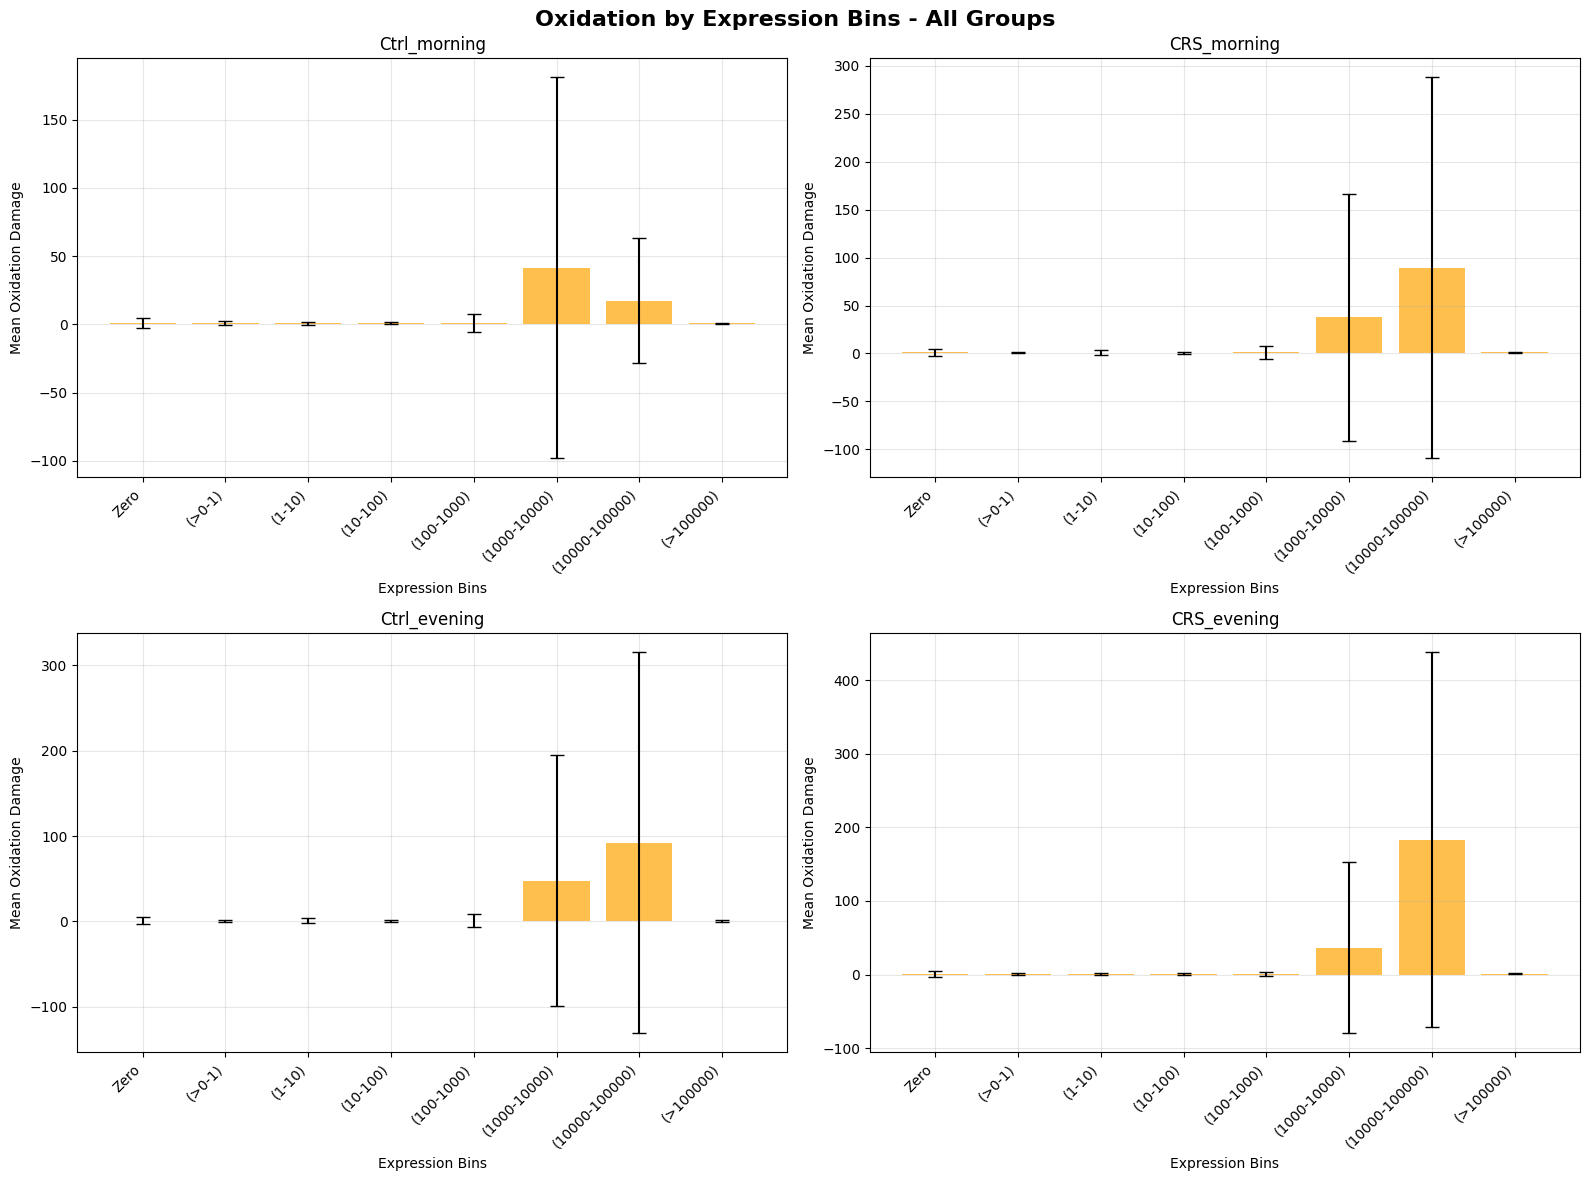


FINAL SUMMARY: CORRELATION BETWEEN OXIDATION DAMAGE AND GENE EXPRESSION

CTRL_MORNING:
--------------------------------------------------
Spearman Rank Correlation: ρ = -0.0396 (p = 0.00e+00)
→ Weak negative correlation, significant
Non-zero expression only: r = 0.0253 (p = 2.09e-151, n = 1,071,620)
Log-transformed model: coef = 0.0048 (R² = 0.0003)
→ Higher oxidation damage associated with higher expression

CRS_MORNING:
--------------------------------------------------
Spearman Rank Correlation: ρ = -0.0277 (p = 0.00e+00)
→ Weak negative correlation, significant
Non-zero expression only: r = 0.0334 (p = 3.96e-259, n = 1,062,350)
Log-transformed model: coef = 0.0059 (R² = 0.0004)
→ Higher oxidation damage associated with higher expression

CTRL_EVENING:
--------------------------------------------------
Spearman Rank Correlation: ρ = -0.0391 (p = 0.00e+00)
→ Weak negative correlation, significant
Non-zero expression only: r = 0.0245 (p = 8.74e-143, n = 1,078,000)
Log-transformed mod

In [30]:
EXPR_PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/Mouse_brain_Sept2024/gene_annotation2/CRS_Morning_Evening_TPM_rearr.csv"
OXID_PATH = "../data_normalized/promoters_Normalized.csv"

expr_df, oxid_df = load_data(EXPR_PATH, OXID_PATH)
        
# Merge data
merged_df = merge_data_for_correlation(expr_df, oxid_df)
        
# Detailed zero inflation analysis
analysis_results = analyze_zero_inflation_detailed(merged_df)
        
# Robust correlation analysis (avoiding problematic Poisson regression)
correlation_results = robust_correlation_analysis(analysis_results)
        
# Create robust visualizations
create_robust_visualizations_separate_rows(analysis_results, correlation_results)
        
# Print final summary
print_final_summary(correlation_results)
        
print(f"\nAnalysis complete! Used robust methods appropriate for zero-inflated expression data.")